# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 24139 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.all, durl=Durl.all, max_distance=2)


  0% (    1 of 24139) |             | Elapsed Time: 0:00:04 ETA:  1 day, 4:06:13

  0% (   79 of 24139) |                    | Elapsed Time: 0:00:05 ETA:  0:05:04

  0% (  164 of 24139) |                    | Elapsed Time: 0:00:06 ETA:  0:04:54

  0% (  237 of 24139) |                    | Elapsed Time: 0:00:07 ETA:  0:05:04

  1% (  302 of 24139) |                    | Elapsed Time: 0:00:08 ETA:  0:05:09

  1% (  374 of 24139) |                    | Elapsed Time: 0:00:09 ETA:  0:05:12

  1% (  458 of 24139) |                    | Elapsed Time: 0:00:10 ETA:  0:05:06

  2% (  545 of 24139) |                    | Elapsed Time: 0:00:11 ETA:  0:04:59

  2% (  604 of 24139) |                    | Elapsed Time: 0:00:11 ETA:  0:04:56

  2% (  689 of 24139) |                    | Elapsed Time: 0:00:12 ETA:  0:04:52

  3% (  775 of 24139) |                    | Elapsed Time: 0:00:13 ETA:  0:04:48

  3% (  848 of 24139) |                    | Elapsed Time: 0:00:14 ETA:  0:04:51

  3% (  906 of 24139) |                    | Elapsed Time: 0:00:15 ETA:  0:04:47

  4% (  985 of 24139) |                    | Elapsed Time: 0:00:16 ETA:  0:04:43

  4% ( 1042 of 24139) |                    | Elapsed Time: 0:00:17 ETA:  0:04:50

  4% ( 1125 of 24139) |                    | Elapsed Time: 0:00:18 ETA:  0:04:49

  4% ( 1193 of 24139) |                    | Elapsed Time: 0:00:19 ETA:  0:04:57

  5% ( 1207 of 24139) |#                   | Elapsed Time: 0:00:19 ETA:  0:05:02

  5% ( 1291 of 24139) |#                   | Elapsed Time: 0:00:20 ETA:  0:05:02

  5% ( 1371 of 24139) |#                   | Elapsed Time: 0:00:21 ETA:  0:05:04

  6% ( 1461 of 24139) |#                   | Elapsed Time: 0:00:22 ETA:  0:04:53

  6% ( 1509 of 24139) |#                   | Elapsed Time: 0:00:23 ETA:  0:04:50

  6% ( 1605 of 24139) |#                   | Elapsed Time: 0:00:24 ETA:  0:04:40

  6% ( 1683 of 24139) |#                   | Elapsed Time: 0:00:25 ETA:  0:04:28

  7% ( 1761 of 24139) |#                   | Elapsed Time: 0:00:26 ETA:  0:04:29

  7% ( 1811 of 24139) |#                   | Elapsed Time: 0:00:27 ETA:  0:04:25

  7% ( 1897 of 24139) |#                   | Elapsed Time: 0:00:28 ETA:  0:04:20

  8% ( 1985 of 24139) |#                   | Elapsed Time: 0:00:29 ETA:  0:04:17

  8% ( 2046 of 24139) |#                   | Elapsed Time: 0:00:30 ETA:  0:04:24

  8% ( 2113 of 24139) |#                   | Elapsed Time: 0:00:31 ETA:  0:04:27

  9% ( 2193 of 24139) |#                   | Elapsed Time: 0:00:32 ETA:  0:04:29

  9% ( 2263 of 24139) |#                   | Elapsed Time: 0:00:33 ETA:  0:04:40

  9% ( 2346 of 24139) |#                   | Elapsed Time: 0:00:34 ETA:  0:04:37

 10% ( 2414 of 24139) |##                  | Elapsed Time: 0:00:35 ETA:  0:04:39

 10% ( 2475 of 24139) |##                  | Elapsed Time: 0:00:36 ETA:  0:04:45

 10% ( 2558 of 24139) |##                  | Elapsed Time: 0:00:37 ETA:  0:04:46

 10% ( 2645 of 24139) |##                  | Elapsed Time: 0:00:38 ETA:  0:04:45

 11% ( 2692 of 24139) |##                  | Elapsed Time: 0:00:39 ETA:  0:04:51

 11% ( 2716 of 24139) |##                  | Elapsed Time: 0:00:39 ETA:  0:04:53

 11% ( 2794 of 24139) |##                  | Elapsed Time: 0:00:40 ETA:  0:04:53

 11% ( 2874 of 24139) |##                  | Elapsed Time: 0:00:41 ETA:  0:04:47

 12% ( 2948 of 24139) |##                  | Elapsed Time: 0:00:42 ETA:  0:04:50

 12% ( 3018 of 24139) |##                  | Elapsed Time: 0:00:43 ETA:  0:04:45

 12% ( 3077 of 24139) |##                  | Elapsed Time: 0:00:44 ETA:  0:04:45

 13% ( 3163 of 24139) |##                  | Elapsed Time: 0:00:45 ETA:  0:04:42

 13% ( 3250 of 24139) |##                  | Elapsed Time: 0:00:46 ETA:  0:04:41

 13% ( 3320 of 24139) |##                  | Elapsed Time: 0:00:47 ETA:  0:04:22

 14% ( 3395 of 24139) |##                  | Elapsed Time: 0:00:48 ETA:  0:04:24

 14% ( 3480 of 24139) |##                  | Elapsed Time: 0:00:49 ETA:  0:04:20

 14% ( 3555 of 24139) |##                  | Elapsed Time: 0:00:50 ETA:  0:04:21

 15% ( 3621 of 24139) |###                 | Elapsed Time: 0:00:50 ETA:  0:04:17

 15% ( 3710 of 24139) |###                 | Elapsed Time: 0:00:51 ETA:  0:04:12

 15% ( 3794 of 24139) |###                 | Elapsed Time: 0:00:52 ETA:  0:04:01

 16% ( 3876 of 24139) |###                 | Elapsed Time: 0:00:53 ETA:  0:04:01

 16% ( 3923 of 24139) |###                 | Elapsed Time: 0:00:54 ETA:  0:04:06

 16% ( 4001 of 24139) |###                 | Elapsed Time: 0:00:55 ETA:  0:04:07

 16% ( 4078 of 24139) |###                 | Elapsed Time: 0:00:56 ETA:  0:04:04

 17% ( 4143 of 24139) |###                 | Elapsed Time: 0:00:57 ETA:  0:04:13

 17% ( 4201 of 24139) |###                 | Elapsed Time: 0:00:58 ETA:  0:04:20

 17% ( 4225 of 24139) |###                 | Elapsed Time: 0:00:58 ETA:  0:04:21

 17% ( 4295 of 24139) |###                 | Elapsed Time: 0:00:59 ETA:  0:04:30

 18% ( 4357 of 24139) |###                 | Elapsed Time: 0:01:01 ETA:  0:04:42

 18% ( 4425 of 24139) |###                 | Elapsed Time: 0:01:02 ETA:  0:04:50

 18% ( 4508 of 24139) |###                 | Elapsed Time: 0:01:03 ETA:  0:04:41

 18% ( 4527 of 24139) |###                 | Elapsed Time: 0:01:03 ETA:  0:04:44

 19% ( 4621 of 24139) |###                 | Elapsed Time: 0:01:04 ETA:  0:04:32

 19% ( 4708 of 24139) |###                 | Elapsed Time: 0:01:05 ETA:  0:04:18

 19% ( 4802 of 24139) |###                 | Elapsed Time: 0:01:06 ETA:  0:03:57

 20% ( 4828 of 24139) |####                | Elapsed Time: 0:01:06 ETA:  0:03:57

 20% ( 4879 of 24139) |####                | Elapsed Time: 0:01:07 ETA:  0:04:05

 20% ( 4966 of 24139) |####                | Elapsed Time: 0:01:08 ETA:  0:03:51

 20% ( 5048 of 24139) |####                | Elapsed Time: 0:01:09 ETA:  0:03:43

 21% ( 5130 of 24139) |####                | Elapsed Time: 0:01:10 ETA:  0:03:42

 21% ( 5195 of 24139) |####                | Elapsed Time: 0:01:11 ETA:  0:03:49

 21% ( 5287 of 24139) |####                | Elapsed Time: 0:01:12 ETA:  0:03:49

 22% ( 5364 of 24139) |####                | Elapsed Time: 0:01:13 ETA:  0:03:53

 22% ( 5432 of 24139) |####                | Elapsed Time: 0:01:14 ETA:  0:04:02

 22% ( 5525 of 24139) |####                | Elapsed Time: 0:01:15 ETA:  0:03:55

 23% ( 5612 of 24139) |####                | Elapsed Time: 0:01:16 ETA:  0:03:39

 23% ( 5698 of 24139) |####                | Elapsed Time: 0:01:17 ETA:  0:03:38

 23% ( 5734 of 24139) |####                | Elapsed Time: 0:01:17 ETA:  0:03:37

 24% ( 5814 of 24139) |####                | Elapsed Time: 0:01:18 ETA:  0:03:37

 24% ( 5908 of 24139) |####                | Elapsed Time: 0:01:19 ETA:  0:03:25

 24% ( 5980 of 24139) |####                | Elapsed Time: 0:01:20 ETA:  0:03:31

 25% ( 6035 of 24139) |#####               | Elapsed Time: 0:01:21 ETA:  0:03:30

 25% ( 6118 of 24139) |#####               | Elapsed Time: 0:01:22 ETA:  0:03:25

 25% ( 6209 of 24139) |#####               | Elapsed Time: 0:01:23 ETA:  0:03:24

 26% ( 6295 of 24139) |#####               | Elapsed Time: 0:01:24 ETA:  0:03:24

 26% ( 6337 of 24139) |#####               | Elapsed Time: 0:01:25 ETA:  0:03:24

 26% ( 6416 of 24139) |#####               | Elapsed Time: 0:01:26 ETA:  0:03:26

 26% ( 6501 of 24139) |#####               | Elapsed Time: 0:01:27 ETA:  0:03:23

 27% ( 6581 of 24139) |#####               | Elapsed Time: 0:01:28 ETA:  0:03:27

 27% ( 6639 of 24139) |#####               | Elapsed Time: 0:01:28 ETA:  0:03:21

 27% ( 6724 of 24139) |#####               | Elapsed Time: 0:01:29 ETA:  0:03:17

 28% ( 6792 of 24139) |#####               | Elapsed Time: 0:01:30 ETA:  0:03:22

 28% ( 6870 of 24139) |#####               | Elapsed Time: 0:01:31 ETA:  0:03:27

 28% ( 6940 of 24139) |#####               | Elapsed Time: 0:01:32 ETA:  0:03:27

 29% ( 7027 of 24139) |#####               | Elapsed Time: 0:01:33 ETA:  0:03:24

 29% ( 7114 of 24139) |#####               | Elapsed Time: 0:01:34 ETA:  0:03:19

 29% ( 7203 of 24139) |#####               | Elapsed Time: 0:01:35 ETA:  0:03:16

 30% ( 7242 of 24139) |######              | Elapsed Time: 0:01:36 ETA:  0:03:14

 30% ( 7320 of 24139) |######              | Elapsed Time: 0:01:37 ETA:  0:03:16

 30% ( 7407 of 24139) |######              | Elapsed Time: 0:01:38 ETA:  0:03:15

 31% ( 7490 of 24139) |######              | Elapsed Time: 0:01:39 ETA:  0:03:08

 31% ( 7544 of 24139) |######              | Elapsed Time: 0:01:39 ETA:  0:03:04

 31% ( 7630 of 24139) |######              | Elapsed Time: 0:01:40 ETA:  0:03:03

 31% ( 7701 of 24139) |######              | Elapsed Time: 0:01:41 ETA:  0:03:08

 32% ( 7787 of 24139) |######              | Elapsed Time: 0:01:42 ETA:  0:03:08

 32% ( 7846 of 24139) |######              | Elapsed Time: 0:01:43 ETA:  0:03:12

 32% ( 7916 of 24139) |######              | Elapsed Time: 0:01:44 ETA:  0:03:29

 33% ( 7999 of 24139) |######              | Elapsed Time: 0:01:45 ETA:  0:03:25

 33% ( 8086 of 24139) |######              | Elapsed Time: 0:01:46 ETA:  0:03:24

 33% ( 8147 of 24139) |######              | Elapsed Time: 0:01:47 ETA:  0:03:21

 34% ( 8242 of 24139) |######              | Elapsed Time: 0:01:48 ETA:  0:03:15

 34% ( 8334 of 24139) |######              | Elapsed Time: 0:01:49 ETA:  0:03:11

 34% ( 8427 of 24139) |######              | Elapsed Time: 0:01:50 ETA:  0:03:01

 35% ( 8449 of 24139) |#######             | Elapsed Time: 0:01:50 ETA:  0:03:02

 35% ( 8527 of 24139) |#######             | Elapsed Time: 0:01:51 ETA:  0:03:01

 35% ( 8607 of 24139) |#######             | Elapsed Time: 0:01:52 ETA:  0:02:45

 36% ( 8694 of 24139) |#######             | Elapsed Time: 0:01:53 ETA:  0:02:42

 36% ( 8751 of 24139) |#######             | Elapsed Time: 0:01:54 ETA:  0:02:39

 36% ( 8843 of 24139) |#######             | Elapsed Time: 0:01:55 ETA:  0:02:37

 37% ( 8934 of 24139) |#######             | Elapsed Time: 0:01:56 ETA:  0:02:38

 37% ( 9018 of 24139) |#######             | Elapsed Time: 0:01:57 ETA:  0:02:40

 37% ( 9053 of 24139) |#######             | Elapsed Time: 0:01:57 ETA:  0:02:42

 37% ( 9145 of 24139) |#######             | Elapsed Time: 0:01:58 ETA:  0:02:39

 38% ( 9238 of 24139) |#######             | Elapsed Time: 0:01:59 ETA:  0:02:33

 38% ( 9323 of 24139) |#######             | Elapsed Time: 0:02:00 ETA:  0:02:30

 38% ( 9354 of 24139) |#######             | Elapsed Time: 0:02:01 ETA:  0:02:32

 39% ( 9435 of 24139) |#######             | Elapsed Time: 0:02:02 ETA:  0:02:36

 39% ( 9526 of 24139) |#######             | Elapsed Time: 0:02:03 ETA:  0:02:35

 39% ( 9606 of 24139) |#######             | Elapsed Time: 0:02:04 ETA:  0:02:39

 40% ( 9656 of 24139) |########            | Elapsed Time: 0:02:04 ETA:  0:02:34

 40% ( 9745 of 24139) |########            | Elapsed Time: 0:02:05 ETA:  0:02:32

 40% ( 9831 of 24139) |########            | Elapsed Time: 0:02:06 ETA:  0:02:33

 41% ( 9911 of 24139) |########            | Elapsed Time: 0:02:07 ETA:  0:02:37

 41% ( 9958 of 24139) |########            | Elapsed Time: 0:02:08 ETA:  0:02:33

 41% (10045 of 24139) |########            | Elapsed Time: 0:02:09 ETA:  0:02:30

 41% (10132 of 24139) |########            | Elapsed Time: 0:02:10 ETA:  0:02:26

 42% (10214 of 24139) |########            | Elapsed Time: 0:02:11 ETA:  0:02:29

 42% (10260 of 24139) |########            | Elapsed Time: 0:02:12 ETA:  0:02:28

 42% (10339 of 24139) |########            | Elapsed Time: 0:02:13 ETA:  0:02:33

 43% (10412 of 24139) |########            | Elapsed Time: 0:02:14 ETA:  0:02:39

 43% (10499 of 24139) |########            | Elapsed Time: 0:02:15 ETA:  0:02:38

 43% (10561 of 24139) |########            | Elapsed Time: 0:02:15 ETA:  0:02:39

 44% (10642 of 24139) |########            | Elapsed Time: 0:02:16 ETA:  0:02:42

 44% (10722 of 24139) |########            | Elapsed Time: 0:02:17 ETA:  0:02:44

 44% (10802 of 24139) |########            | Elapsed Time: 0:02:18 ETA:  0:02:47

 45% (10863 of 24139) |#########           | Elapsed Time: 0:02:19 ETA:  0:02:44

 45% (10943 of 24139) |#########           | Elapsed Time: 0:02:20 ETA:  0:02:42

 45% (11023 of 24139) |#########           | Elapsed Time: 0:02:21 ETA:  0:02:41

 45% (11100 of 24139) |#########           | Elapsed Time: 0:02:22 ETA:  0:02:39

 46% (11165 of 24139) |#########           | Elapsed Time: 0:02:23 ETA:  0:02:48

 46% (11251 of 24139) |#########           | Elapsed Time: 0:02:24 ETA:  0:02:44

 46% (11341 of 24139) |#########           | Elapsed Time: 0:02:25 ETA:  0:02:38

 47% (11425 of 24139) |#########           | Elapsed Time: 0:02:26 ETA:  0:02:35

 47% (11467 of 24139) |#########           | Elapsed Time: 0:02:27 ETA:  0:02:35

 47% (11553 of 24139) |#########           | Elapsed Time: 0:02:28 ETA:  0:02:31

 48% (11641 of 24139) |#########           | Elapsed Time: 0:02:29 ETA:  0:02:26

 48% (11729 of 24139) |#########           | Elapsed Time: 0:02:30 ETA:  0:02:19

 48% (11768 of 24139) |#########           | Elapsed Time: 0:02:31 ETA:  0:02:32

 49% (11849 of 24139) |#########           | Elapsed Time: 0:02:32 ETA:  0:02:34

 49% (11938 of 24139) |#########           | Elapsed Time: 0:02:33 ETA:  0:02:33

 49% (12025 of 24139) |#########           | Elapsed Time: 0:02:34 ETA:  0:02:31

 50% (12070 of 24139) |##########          | Elapsed Time: 0:02:34 ETA:  0:02:35

 50% (12154 of 24139) |##########          | Elapsed Time: 0:02:35 ETA:  0:02:35

 50% (12232 of 24139) |##########          | Elapsed Time: 0:02:36 ETA:  0:02:40

 51% (12315 of 24139) |##########          | Elapsed Time: 0:02:37 ETA:  0:02:42

 51% (12372 of 24139) |##########          | Elapsed Time: 0:02:38 ETA:  0:02:14

 51% (12456 of 24139) |##########          | Elapsed Time: 0:02:39 ETA:  0:02:13

 51% (12545 of 24139) |##########          | Elapsed Time: 0:02:40 ETA:  0:02:09

 52% (12625 of 24139) |##########          | Elapsed Time: 0:02:41 ETA:  0:02:12

 52% (12673 of 24139) |##########          | Elapsed Time: 0:02:42 ETA:  0:02:12

 52% (12754 of 24139) |##########          | Elapsed Time: 0:02:43 ETA:  0:02:08

 53% (12841 of 24139) |##########          | Elapsed Time: 0:02:44 ETA:  0:02:06

 53% (12924 of 24139) |##########          | Elapsed Time: 0:02:45 ETA:  0:02:03

 53% (12975 of 24139) |##########          | Elapsed Time: 0:02:45 ETA:  0:02:04

 54% (13061 of 24139) |##########          | Elapsed Time: 0:02:46 ETA:  0:02:02

 54% (13137 of 24139) |##########          | Elapsed Time: 0:02:47 ETA:  0:02:04

 54% (13224 of 24139) |##########          | Elapsed Time: 0:02:48 ETA:  0:02:04

 55% (13277 of 24139) |###########         | Elapsed Time: 0:02:49 ETA:  0:01:59

 55% (13361 of 24139) |###########         | Elapsed Time: 0:02:50 ETA:  0:01:58

 55% (13443 of 24139) |###########         | Elapsed Time: 0:02:51 ETA:  0:01:57

 56% (13531 of 24139) |###########         | Elapsed Time: 0:02:52 ETA:  0:01:55

 56% (13579 of 24139) |###########         | Elapsed Time: 0:02:53 ETA:  0:01:52

 56% (13669 of 24139) |###########         | Elapsed Time: 0:02:54 ETA:  0:01:47

 57% (13762 of 24139) |###########         | Elapsed Time: 0:02:55 ETA:  0:01:43

 57% (13846 of 24139) |###########         | Elapsed Time: 0:02:56 ETA:  0:01:39

 57% (13880 of 24139) |###########         | Elapsed Time: 0:02:56 ETA:  0:01:38

 57% (13961 of 24139) |###########         | Elapsed Time: 0:02:57 ETA:  0:01:42

 58% (14051 of 24139) |###########         | Elapsed Time: 0:02:58 ETA:  0:01:39

 58% (14129 of 24139) |###########         | Elapsed Time: 0:02:59 ETA:  0:01:40

 58% (14182 of 24139) |###########         | Elapsed Time: 0:03:00 ETA:  0:01:39

 59% (14271 of 24139) |###########         | Elapsed Time: 0:03:01 ETA:  0:01:39

 59% (14359 of 24139) |###########         | Elapsed Time: 0:03:02 ETA:  0:01:38

 59% (14437 of 24139) |###########         | Elapsed Time: 0:03:03 ETA:  0:01:44

 60% (14484 of 24139) |############        | Elapsed Time: 0:03:03 ETA:  0:01:47

 60% (14581 of 24139) |############        | Elapsed Time: 0:03:04 ETA:  0:01:41

 60% (14664 of 24139) |############        | Elapsed Time: 0:03:05 ETA:  0:01:40

 61% (14742 of 24139) |############        | Elapsed Time: 0:03:06 ETA:  0:01:43

 61% (14786 of 24139) |############        | Elapsed Time: 0:03:07 ETA:  0:01:39

 61% (14874 of 24139) |############        | Elapsed Time: 0:03:08 ETA:  0:01:37

 61% (14953 of 24139) |############        | Elapsed Time: 0:03:09 ETA:  0:01:40

 62% (15040 of 24139) |############        | Elapsed Time: 0:03:10 ETA:  0:01:39

 62% (15087 of 24139) |############        | Elapsed Time: 0:03:10 ETA:  0:01:35

 62% (15174 of 24139) |############        | Elapsed Time: 0:03:11 ETA:  0:01:30

 63% (15263 of 24139) |############        | Elapsed Time: 0:03:12 ETA:  0:01:32

 63% (15350 of 24139) |############        | Elapsed Time: 0:03:13 ETA:  0:01:29

 63% (15389 of 24139) |############        | Elapsed Time: 0:03:14 ETA:  0:01:24

 64% (15462 of 24139) |############        | Elapsed Time: 0:03:15 ETA:  0:01:30

 64% (15530 of 24139) |############        | Elapsed Time: 0:03:16 ETA:  0:01:38

 64% (15617 of 24139) |############        | Elapsed Time: 0:03:17 ETA:  0:01:33

 65% (15691 of 24139) |#############       | Elapsed Time: 0:03:18 ETA:  0:01:32

 65% (15778 of 24139) |#############       | Elapsed Time: 0:03:19 ETA:  0:01:30

 65% (15863 of 24139) |#############       | Elapsed Time: 0:03:20 ETA:  0:01:30

 66% (15947 of 24139) |#############       | Elapsed Time: 0:03:21 ETA:  0:01:31

 66% (15993 of 24139) |#############       | Elapsed Time: 0:03:21 ETA:  0:01:31

 66% (16071 of 24139) |#############       | Elapsed Time: 0:03:22 ETA:  0:01:34

 66% (16160 of 24139) |#############       | Elapsed Time: 0:03:23 ETA:  0:01:26

 67% (16248 of 24139) |#############       | Elapsed Time: 0:03:24 ETA:  0:01:17

 67% (16294 of 24139) |#############       | Elapsed Time: 0:03:25 ETA:  0:01:16

 67% (16367 of 24139) |#############       | Elapsed Time: 0:03:26 ETA:  0:01:45

 68% (16435 of 24139) |#############       | Elapsed Time: 0:03:27 ETA:  0:01:53

 68% (16524 of 24139) |#############       | Elapsed Time: 0:03:28 ETA:  0:01:50

 68% (16596 of 24139) |#############       | Elapsed Time: 0:03:29 ETA:  0:01:51

 69% (16678 of 24139) |#############       | Elapsed Time: 0:03:30 ETA:  0:01:50

 69% (16765 of 24139) |#############       | Elapsed Time: 0:03:31 ETA:  0:01:45

 69% (16815 of 24139) |#############       | Elapsed Time: 0:03:32 ETA:  0:02:03

 70% (16898 of 24139) |##############      | Elapsed Time: 0:03:33 ETA:  0:02:02

 70% (16983 of 24139) |##############      | Elapsed Time: 0:03:34 ETA:  0:01:59

 70% (17075 of 24139) |##############      | Elapsed Time: 0:03:35 ETA:  0:01:27

 71% (17159 of 24139) |##############      | Elapsed Time: 0:03:36 ETA:  0:01:19

 71% (17200 of 24139) |##############      | Elapsed Time: 0:03:37 ETA:  0:01:22

 71% (17280 of 24139) |##############      | Elapsed Time: 0:03:38 ETA:  0:01:21

 71% (17360 of 24139) |##############      | Elapsed Time: 0:03:39 ETA:  0:01:21

 72% (17444 of 24139) |##############      | Elapsed Time: 0:03:40 ETA:  0:01:21

 72% (17501 of 24139) |##############      | Elapsed Time: 0:03:40 ETA:  0:01:05

 72% (17592 of 24139) |##############      | Elapsed Time: 0:03:41 ETA:  0:01:03

 73% (17667 of 24139) |##############      | Elapsed Time: 0:03:42 ETA:  0:01:06

 73% (17747 of 24139) |##############      | Elapsed Time: 0:03:43 ETA:  0:01:10

 73% (17803 of 24139) |##############      | Elapsed Time: 0:03:44 ETA:  0:01:10

 74% (17887 of 24139) |##############      | Elapsed Time: 0:03:45 ETA:  0:01:08

 74% (17977 of 24139) |##############      | Elapsed Time: 0:03:46 ETA:  0:01:02

 74% (18064 of 24139) |##############      | Elapsed Time: 0:03:47 ETA:  0:00:59

 75% (18105 of 24139) |###############     | Elapsed Time: 0:03:48 ETA:  0:00:59

 75% (18193 of 24139) |###############     | Elapsed Time: 0:03:49 ETA:  0:00:58

 75% (18286 of 24139) |###############     | Elapsed Time: 0:03:50 ETA:  0:00:56

 76% (18374 of 24139) |###############     | Elapsed Time: 0:03:51 ETA:  0:00:50

 76% (18406 of 24139) |###############     | Elapsed Time: 0:03:51 ETA:  0:00:47

 76% (18489 of 24139) |###############     | Elapsed Time: 0:03:52 ETA:  0:00:46

 76% (18577 of 24139) |###############     | Elapsed Time: 0:03:53 ETA:  0:00:44

 77% (18662 of 24139) |###############     | Elapsed Time: 0:03:54 ETA:  0:00:45

 77% (18708 of 24139) |###############     | Elapsed Time: 0:03:55 ETA:  0:00:44

 77% (18795 of 24139) |###############     | Elapsed Time: 0:03:56 ETA:  0:00:41

 78% (18872 of 24139) |###############     | Elapsed Time: 0:03:57 ETA:  0:00:44

 78% (18962 of 24139) |###############     | Elapsed Time: 0:03:58 ETA:  0:00:45

 78% (19010 of 24139) |###############     | Elapsed Time: 0:03:58 ETA:  0:00:45

 79% (19102 of 24139) |###############     | Elapsed Time: 0:03:59 ETA:  0:00:42

 79% (19189 of 24139) |###############     | Elapsed Time: 0:04:00 ETA:  0:00:39

 79% (19277 of 24139) |###############     | Elapsed Time: 0:04:01 ETA:  0:00:38

 80% (19312 of 24139) |################    | Elapsed Time: 0:04:02 ETA:  0:00:37

 80% (19399 of 24139) |################    | Elapsed Time: 0:04:03 ETA:  0:00:37

 80% (19469 of 24139) |################    | Elapsed Time: 0:04:04 ETA:  0:00:43

 81% (19557 of 24139) |################    | Elapsed Time: 0:04:05 ETA:  0:00:37

 81% (19613 of 24139) |################    | Elapsed Time: 0:04:05 ETA:  0:00:39

 81% (19691 of 24139) |################    | Elapsed Time: 0:04:06 ETA:  0:00:41

 81% (19769 of 24139) |################    | Elapsed Time: 0:04:07 ETA:  0:00:46

 82% (19848 of 24139) |################    | Elapsed Time: 0:04:08 ETA:  0:00:49

 82% (19915 of 24139) |################    | Elapsed Time: 0:04:09 ETA:  0:00:47

 82% (19997 of 24139) |################    | Elapsed Time: 0:04:10 ETA:  0:00:47

 83% (20083 of 24139) |################    | Elapsed Time: 0:04:11 ETA:  0:00:46

 83% (20161 of 24139) |################    | Elapsed Time: 0:04:12 ETA:  0:00:41

 83% (20217 of 24139) |################    | Elapsed Time: 0:04:13 ETA:  0:00:46

 84% (20304 of 24139) |################    | Elapsed Time: 0:04:14 ETA:  0:00:43

 84% (20392 of 24139) |################    | Elapsed Time: 0:04:15 ETA:  0:00:38

 84% (20484 of 24139) |################    | Elapsed Time: 0:04:16 ETA:  0:00:31

 85% (20519 of 24139) |#################   | Elapsed Time: 0:04:16 ETA:  0:00:26

 85% (20606 of 24139) |#################   | Elapsed Time: 0:04:17 ETA:  0:00:26

 85% (20697 of 24139) |#################   | Elapsed Time: 0:04:18 ETA:  0:00:22

 86% (20786 of 24139) |#################   | Elapsed Time: 0:04:19 ETA:  0:00:20

 86% (20820 of 24139) |#################   | Elapsed Time: 0:04:20 ETA:  0:00:15

 86% (20900 of 24139) |#################   | Elapsed Time: 0:04:21 ETA:  0:00:14

 86% (20984 of 24139) |#################   | Elapsed Time: 0:04:22 ETA:  0:00:14

 87% (21065 of 24139) |#################   | Elapsed Time: 0:04:23 ETA:  0:00:16

 87% (21122 of 24139) |#################   | Elapsed Time: 0:04:23 ETA:  0:00:16

 87% (21206 of 24139) |#################   | Elapsed Time: 0:04:24 ETA:  0:00:18

 88% (21293 of 24139) |#################   | Elapsed Time: 0:04:25 ETA:  0:00:17

 88% (21358 of 24139) |#################   | Elapsed Time: 0:04:26 ETA:  0:00:28

 88% (21424 of 24139) |#################   | Elapsed Time: 0:04:27 ETA:  0:00:30

 89% (21514 of 24139) |#################   | Elapsed Time: 0:04:28 ETA:  0:00:27

 89% (21602 of 24139) |#################   | Elapsed Time: 0:04:29 ETA:  0:00:22

 89% (21689 of 24139) |#################   | Elapsed Time: 0:04:30 ETA:  0:00:20

 90% (21726 of 24139) |##################  | Elapsed Time: 0:04:30 ETA:  0:00:19

 90% (21817 of 24139) |##################  | Elapsed Time: 0:04:31 ETA:  0:00:17

 90% (21906 of 24139) |##################  | Elapsed Time: 0:04:33 ETA:  0:00:14

 91% (21989 of 24139) |##################  | Elapsed Time: 0:04:34 ETA:  0:00:14

 91% (22027 of 24139) |##################  | Elapsed Time: 0:04:34 ETA:  0:00:09

 91% (22049 of 24139) |##################  | Elapsed Time: 0:04:35 ETA:  0:00:45

 91% (22127 of 24139) |##################  | Elapsed Time: 0:04:36 ETA:  0:00:51

 92% (22213 of 24139) |##################  | Elapsed Time: 0:04:37 ETA:  0:00:51

 92% (22294 of 24139) |##################  | Elapsed Time: 0:04:38 ETA:  0:00:53

 92% (22329 of 24139) |##################  | Elapsed Time: 0:04:39 ETA:  0:00:53

 92% (22414 of 24139) |##################  | Elapsed Time: 0:04:40 ETA:  0:00:55

 93% (22494 of 24139) |##################  | Elapsed Time: 0:04:41 ETA:  0:00:59

 93% (22571 of 24139) |##################  | Elapsed Time: 0:04:42 ETA:  0:01:01

 93% (22631 of 24139) |##################  | Elapsed Time: 0:04:43 ETA:  0:01:00

 94% (22714 of 24139) |##################  | Elapsed Time: 0:04:44 ETA:  0:00:17

 94% (22793 of 24139) |##################  | Elapsed Time: 0:04:45 ETA:  0:00:16

 94% (22864 of 24139) |##################  | Elapsed Time: 0:04:46 ETA:  0:00:22

 95% (22933 of 24139) |################### | Elapsed Time: 0:04:46 ETA:  0:00:18

 95% (23025 of 24139) |################### | Elapsed Time: 0:04:47 ETA:  0:00:12

 95% (23107 of 24139) |################### | Elapsed Time: 0:04:48 ETA:  0:00:12

 96% (23182 of 24139) |################### | Elapsed Time: 0:04:49 ETA:  0:00:13

 96% (23234 of 24139) |################### | Elapsed Time: 0:04:50 ETA:  0:00:09

 96% (23321 of 24139) |################### | Elapsed Time: 0:04:51 ETA:  0:00:02

 96% (23398 of 24139) |################### | Elapsed Time: 0:04:52 ETA:  0:00:03

 97% (23480 of 24139) |################### | Elapsed Time: 0:04:53 ETA:  0:00:01

 97% (23536 of 24139) |################### | Elapsed Time: 0:04:54 ETA:  0:00:00

 97% (23620 of 24139) |################### | Elapsed Time: 0:04:55 ETA:  0:00:00

 98% (23706 of 24139) |################### | Elapsed Time: 0:04:56 ETA:  0:00:00

 98% (23789 of 24139) |################### | Elapsed Time: 0:04:57 ETA:  0:00:00

 98% (23838 of 24139) |################### | Elapsed Time: 0:04:57 ETA:  0:00:00

 99% (23922 of 24139) |################### | Elapsed Time: 0:04:58 ETA:  0:00:00

 99% (23999 of 24139) |################### | Elapsed Time: 0:04:59 ETA:  0:00:00

 99% (24076 of 24139) |################### | Elapsed Time: 0:05:00 ETA:  0:00:00

100% (24139 of 24139) |####################| Elapsed Time: 0:05:01 Time: 0:05:01


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

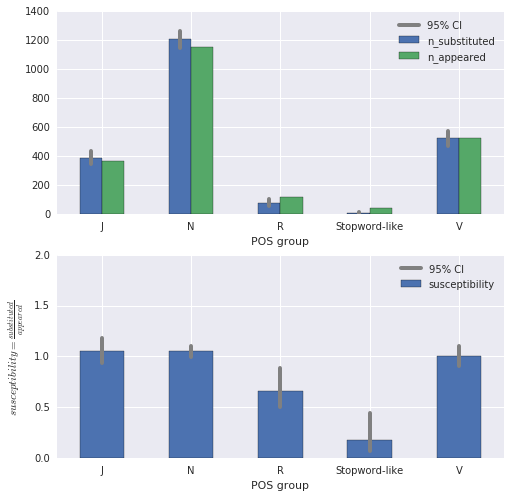

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.001)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


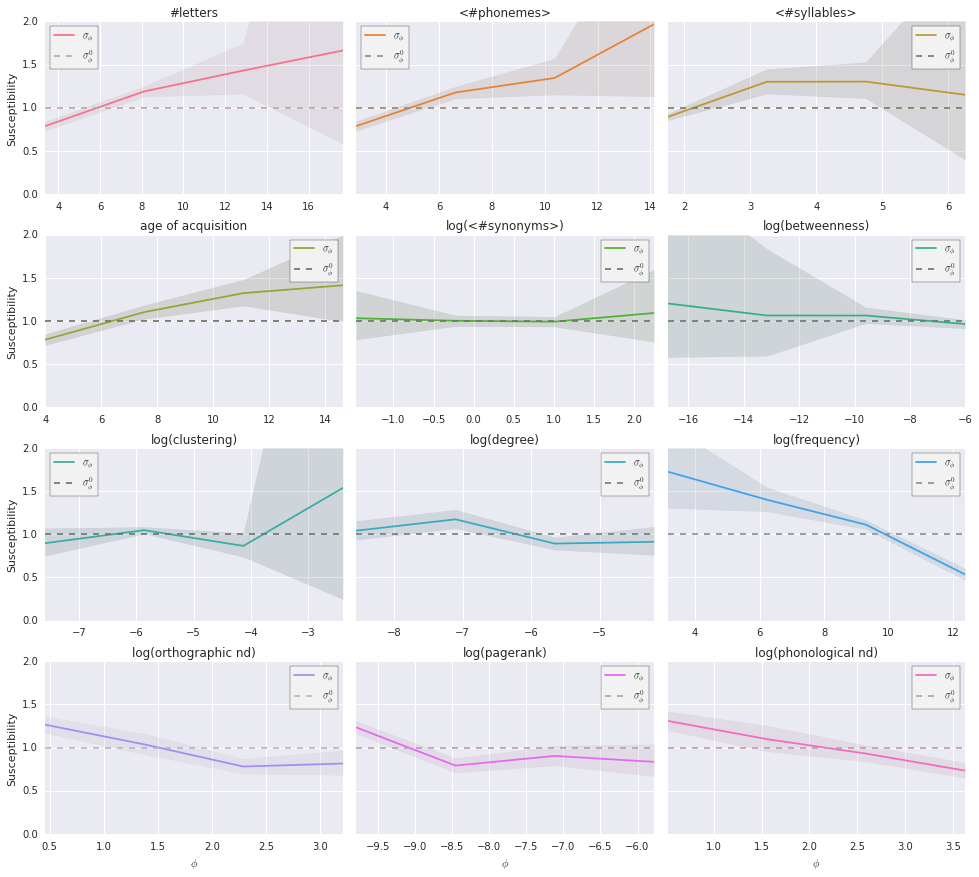

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


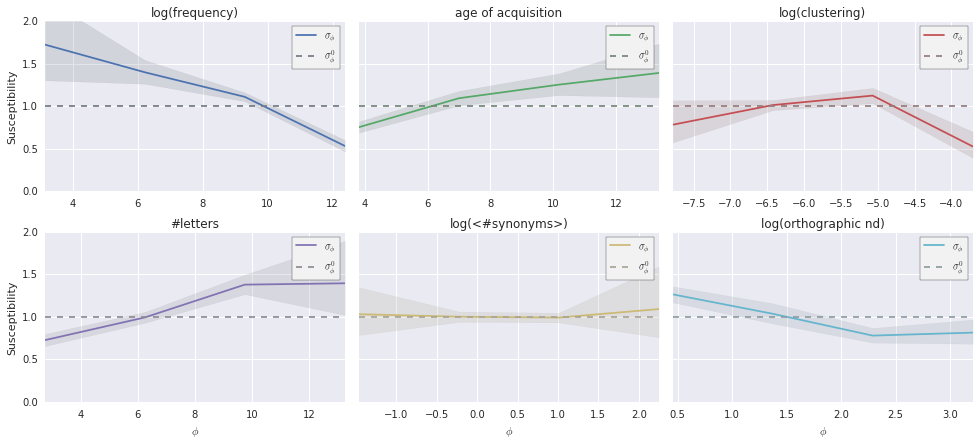

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


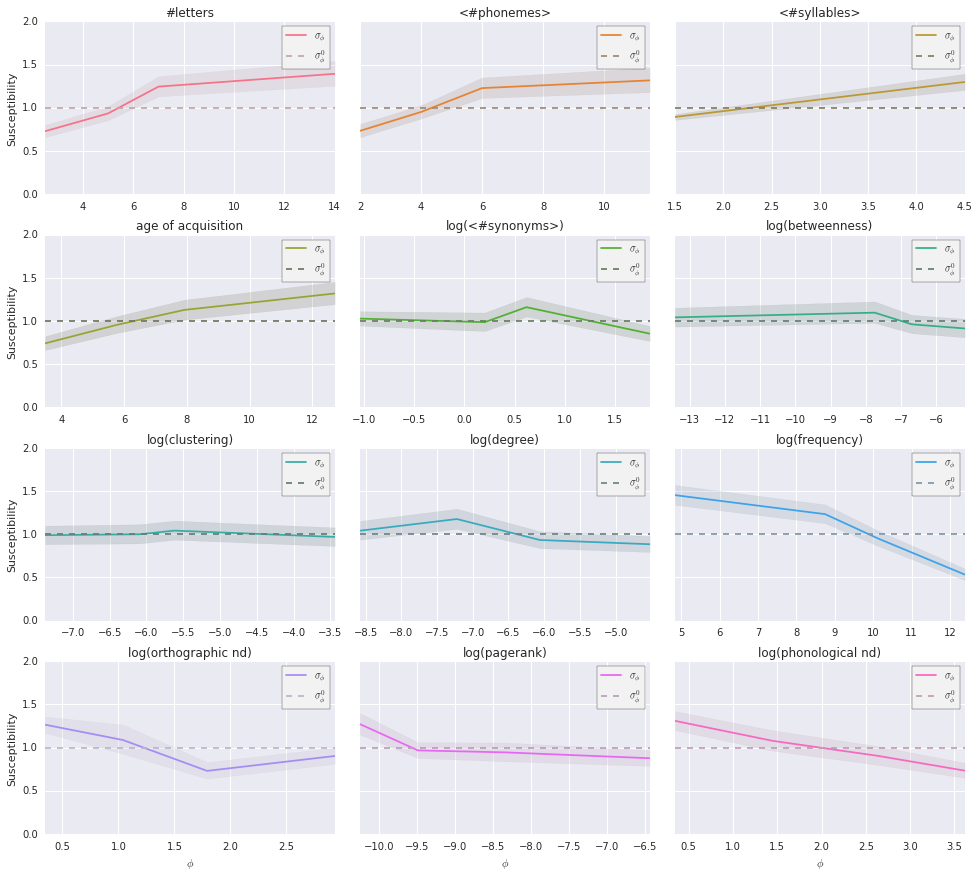

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


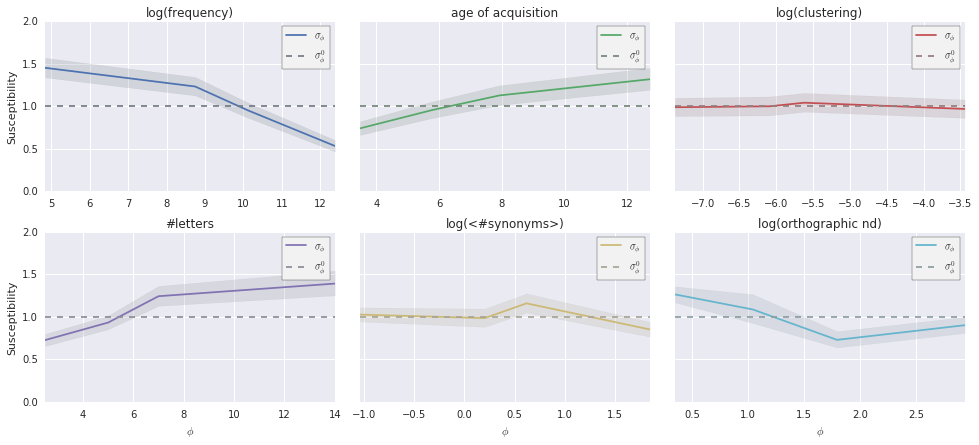

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


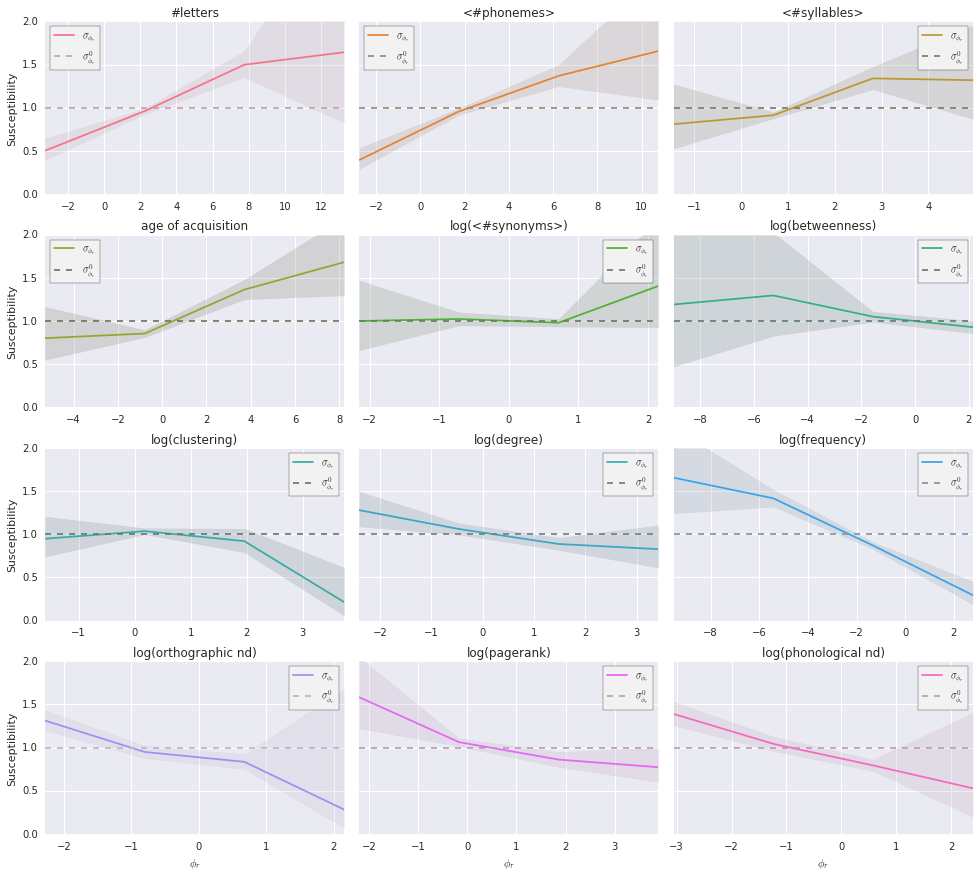

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


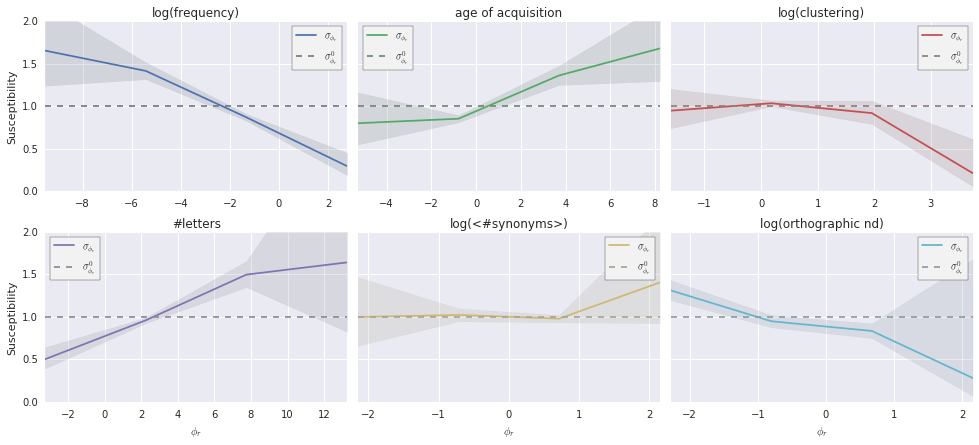

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 3] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 3] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 3] out of region: [1, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


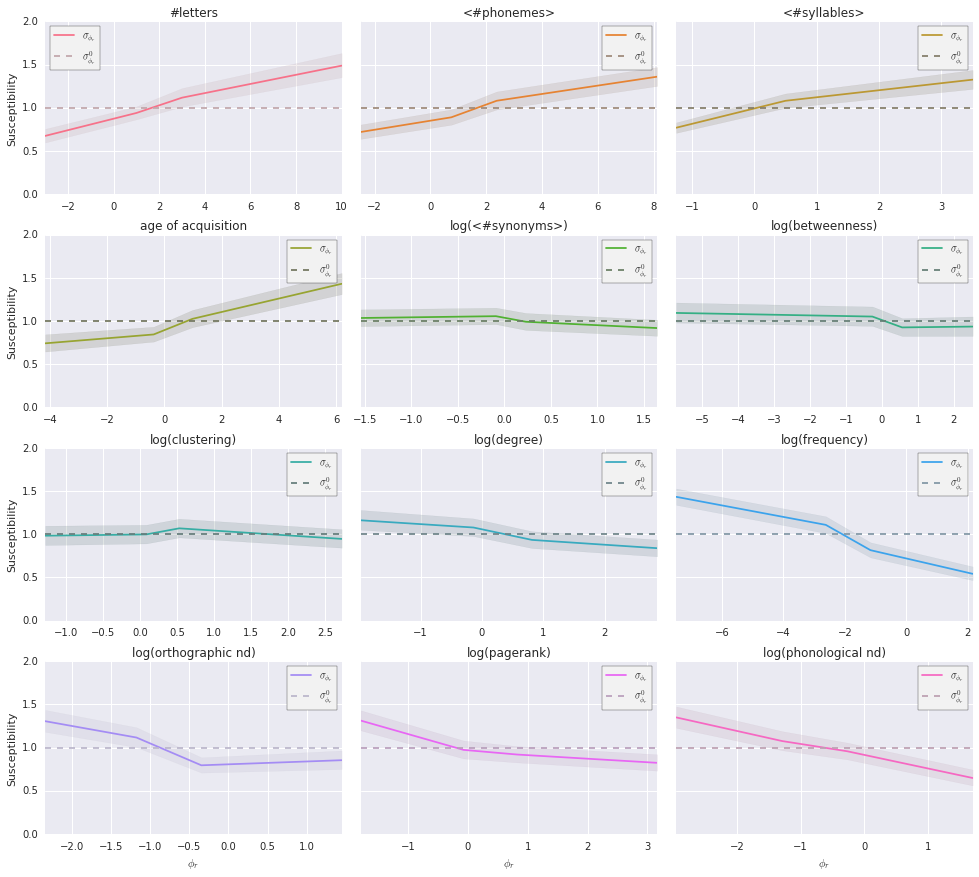

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


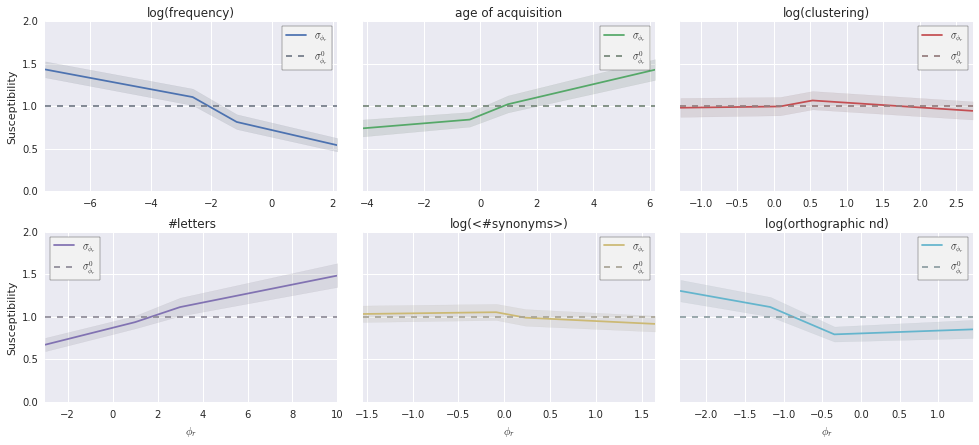

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


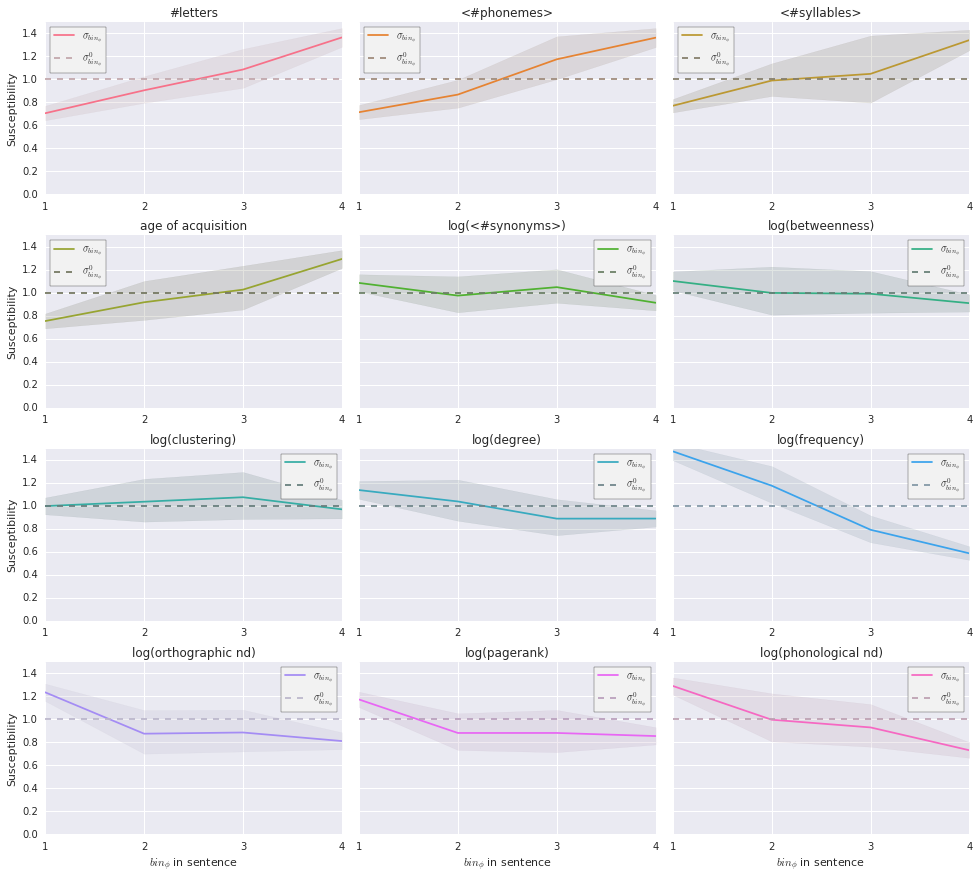

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


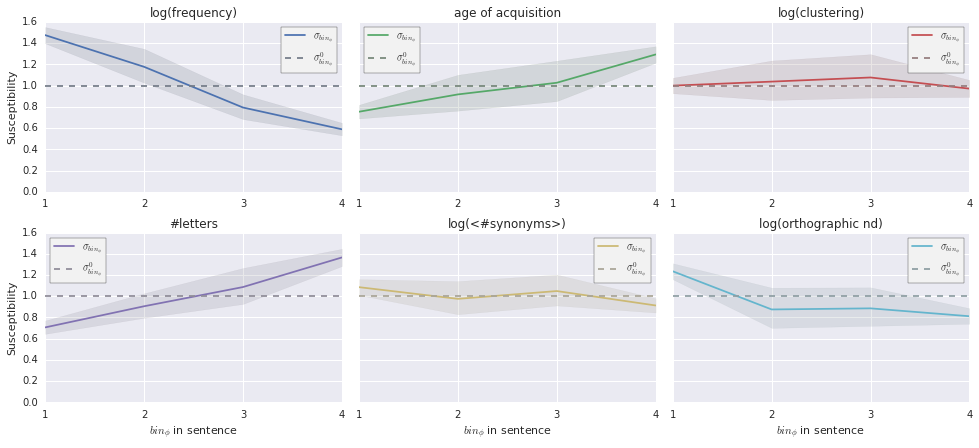

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


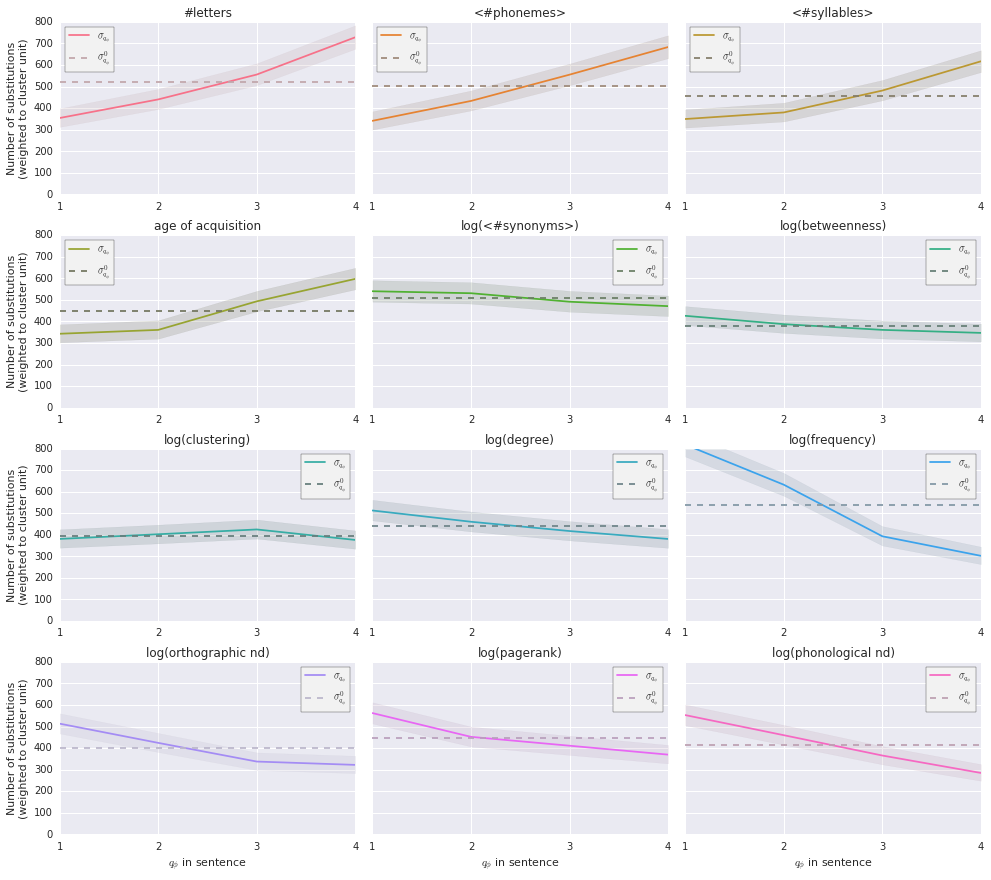

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


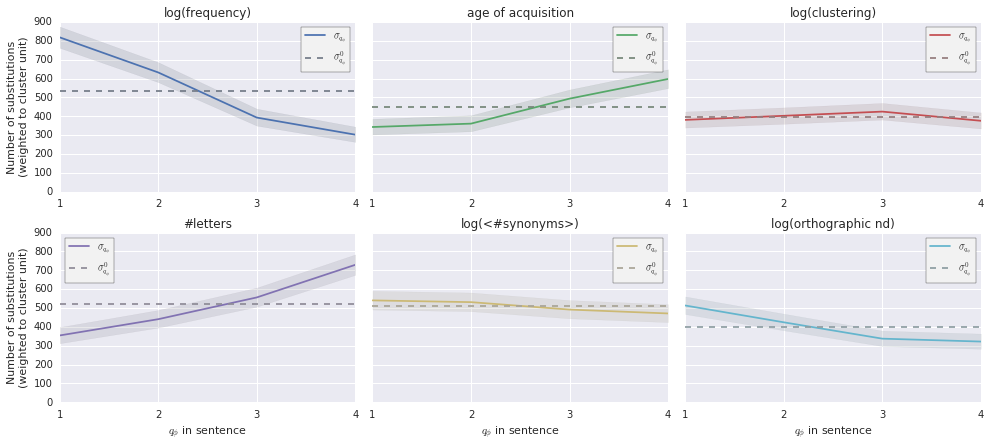

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 56559 word measures (divided into training and prediction sets)



48.52% of words well predicted (non-random at p = 6e-07)
Precision = 0.25
Recall = 0.55

Coefficients:
intercept                                             2.908004
global_frequency                                     -0.311971
global_aoa                                           -0.461055
global_letters_count                                  0.244122
global_orthographic_density                           0.062552
global_frequency * global_aoa                         0.050229
global_frequency * global_letters_count              -0.030202
global_frequency * global_orthographic_density        0.016708
global_aoa * global_letters_count                     0.004971
global_aoa * global_orthographic_density             -0.006070
global_letters_count * global_orthographic_density   -0.034181
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 56559 word measures (divided into training and prediction sets)

63.25% of words well predicted (non-random at p = 5e-324)
Precision = 0.34
Recall = 0.51

Coefficients:
intercept                                                        -0.326087
sentence-rel_frequency                                           -0.163212
sentence-rel_aoa                                                  0.071451
sentence-rel_letters_count                                       -0.095895
sentence-rel_orthographic_density                                 0.090142
sentence-rel_frequency * sentence-rel_aoa                         0.023476
sentence-rel_frequency * sentence-rel_letters_count              -0.020751
sentence-rel_frequency * sentence-rel_orthographic_density        0.010652
sentence-rel_aoa * sentence-rel_letters_count                     0.021893
sentence-rel_aoa * sentence-rel_orthographic_density              0.019609
sentence-rel_letters_count * sentence-rel_orthographic_density   

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 56559 word measures (divided into training and prediction sets)



63.82% of words well predicted (non-random at p = 5e-324)
Precision = 0.34
Recall = 0.50

Coefficients:
intercept                                                         -0.675893
sentence-rel_frequency                                            -0.541934
sentence-rel_aoa                                                  -0.147944
sentence-rel_letters_count                                         0.003009
sentence-rel_orthographic_density                                 -0.091990
global_frequency                                                   0.203320
global_aoa                                                        -0.714810
global_letters_count                                               0.380155
global_orthographic_density                                        0.013976
sentence-rel_frequency * sentence-rel_aoa                         -0.066740
sentence-rel_frequency * sentence-rel_letters_count               -0.105783
sentence-rel_frequency * sentence-rel_orthographic_density 

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 56559 word measures (divided into training and prediction sets)



44.16% of words well predicted (non-random at p = 4e-86)
Precision = 0.26
Recall = 0.68

Coefficients:
intercept                                                      -0.486623
bins-global_frequency                                           0.414765
bins-global_aoa                                                 2.323932
bins-global_letters_count                                      -1.274782
bins-global_orthographic_density                               -1.636509
bins-global_frequency * bins-global_aoa                        -0.413873
bins-global_frequency * bins-global_letters_count               0.226460
bins-global_frequency * bins-global_orthographic_density       -0.308020
bins-global_aoa * bins-global_letters_count                    -0.399360
bins-global_aoa * bins-global_orthographic_density             -0.505043
bins-global_letters_count * bins-global_orthographic_density    1.647447
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 56559 word measures (divided into training and prediction sets)



60.27% of words well predicted (non-random at p = 3e-263)
Precision = 0.29
Recall = 0.43

Coefficients:
intercept                                                                 0.657665
quantiles-global_frequency                                               -0.257032
quantiles-global_aoa                                                      0.759795
quantiles-global_letters_count                                            0.097808
quantiles-global_orthographic_density                                    -2.494779
quantiles-global_frequency * quantiles-global_aoa                        -0.520310
quantiles-global_frequency * quantiles-global_letters_count               0.022503
quantiles-global_frequency * quantiles-global_orthographic_density        1.219881
quantiles-global_aoa * quantiles-global_letters_count                     0.301025
quantiles-global_aoa * quantiles-global_orthographic_density              0.213208
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 56559 word measures (divided into training and prediction sets)

68.54% of words well predicted (non-random at p = 5e-324)
Precision = 0.33
Recall = 0.28

Coefficients:
intercept                                                                   0.118997
bins-sentence-rel_frequency                                                -0.420438
bins-sentence-rel_aoa                                                       0.113583
bins-sentence-rel_letters_count                                             0.075668
bins-sentence-rel_orthographic_density                                      0.118997
bins-sentence-rel_frequency * bins-sentence-rel_aoa                         0.026183
bins-sentence-rel_frequency * bins-sentence-rel_letters_count               0.013704
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.420438
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                    -0.005609
bins-sentence-rel_aoa * bins-sentence-rel_orthogra

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 56559 word measures (divided into training and prediction sets)

56.35% of words well predicted (non-random at p = 2e-101)
Precision = 0.30
Recall = 0.57

Coefficients:
intercept                                                                             0.249929
quantiles-sentence-rel_frequency                                                      0.094509
quantiles-sentence-rel_aoa                                                           -0.194401
quantiles-sentence-rel_letters_count                                                 -0.145760
quantiles-sentence-rel_orthographic_density                                          -0.223487
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.008117
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.202689
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density       -0.015675
quantiles-sentence-rel_aoa * quantiles-sentence-rel_let

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 56559 word measures (divided into training and prediction sets)

66.59% of words well predicted (non-random at p = 5e-324)
Precision = 0.38
Recall = 0.55

Coefficients:
intercept                                                                -0.179042
in-sentence-bins_frequency                                               -0.236241
in-sentence-bins_aoa                                                      0.125859
in-sentence-bins_letters_count                                            0.194574
in-sentence-bins_orthographic_density                                     0.123770
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.033783
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.041536
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.019854
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.008067
in-sentence-bins_aoa * in-sentence-bins_orthographic_density        

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 1742 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.70471386  0.16722114]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.351679 -0.619631
aoa           -0.735102  0.281316
letters_count -0.579609 -0.732748


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 1742 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.63951567  0.19549152]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.466729 -0.700113
aoa           -0.646401  0.146964
letters_count -0.603598 -0.698744
